__Forward encoding model based on Pim Mostert Decoding toolbox__

Alexis Pérez Bellido (2022)

In [1]:
!pwd

/Users/junjieji/Desktop/master-thesis


In [2]:
import sys
path_utils = '/decoding_toolbox_py/helper_funcs' 
sys.path.append(path_utils)

In [3]:
# !pip install mat73

In [4]:
# %matplotlib qt
from scipy.io import loadmat
import numpy as np
import pandas as pd
import mat73

import inspect #path_fun = inspect.getfile(StratifiedKFold)
import matplotlib.pyplot as plt
import DecToolbox as dt
#print(sys.path)

Decoding modules

In [5]:
!pwd

/Users/junjieji/Desktop/master-thesis


In [6]:
import mne
import os

In [7]:
path = '/decoding-toolbox_matlab/data/'
path_ori_data = path + 'testdata_orientation.mat'
print(path_ori_data)

path = 'decoding-toolbox_matlab/data/testdata_orientation.mat' 

/decoding-toolbox_matlab/data/testdata_orientation.mat


Loading & preparing orientation data

In [8]:
ori_data = mat73.loadmat(path)

In [9]:
subjs_list = ['s01', 's02', 's03','s04','s05','s07','s08','s09','s10','s11','s12','s13','s14', 's15', 's16','s17','s18','s19','s20','s21','s22','s23','s24','s25','s26','s27' ]
path = 'Cond_CJ_EEG'

In [10]:
epochs = []
for isubj, subject_id in enumerate(subjs_list):
    preproc_path = os.path.join(path, subject_id);
    epoch = mne.read_epochs(preproc_path + '/main_epo.fif',verbose=False)
    epochs.append(epoch.average());
    # print(isubj)

gvaverage = mne.grand_average(epochs[:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

In [11]:
Y = ori_data['Y']
X = ori_data['X']
time = ori_data['time']
label = ori_data['label']

In [12]:
print(Y.shape)
print(X.shape)
print(time.shape)
print(np.shape(label))

(273, 211, 760)
(760,)
(211,)
(273, 1)


In [13]:
subjs_list = ['s01', 
              # 's02', 's03','s04','s05','s07','s08','s09','s10','s11','s12','s13','s14', 's15', 's16','s17','s18','s19','s20','s21','s22','s23','s24','s25','s26','s27' 
              ]
ival = 0
path = 'Cond_CJ_EEG'

all_st_epochs = []
all_st_rawdata = [None] * np.size(subjs_list)
for isubj, subject_id in enumerate(subjs_list):
    preproc_path = os.path.join(path, subject_id);
    epoch = mne.read_epochs(preproc_path + '/mainstim_epo.fif',verbose=False)
    subj_data = {'epoch_dat' : epoch.get_data(), 'metadata' :  epoch.metadata}
    all_st_rawdata[isubj] =  subj_data
    all_st_epochs.append(epoch);
    epoch.metadata
    
Y = all_st_rawdata[ival]['epoch_dat']
Y = np.einsum('kji->jik', Y)

print(Y.shape)

X = np.array(all_st_rawdata[ival]['metadata'].orient)

print(X.shape)


(32, 201, 1563)
(1563,)


In [14]:
phi = X * (180/8);   # Presented orientation in degrees
binned_phi = np.digitize(phi, bins = np.array([  0, 22.5, 45, 67.5, 90, 112.5, 135, 157.5 ]) ) # bins collapsing degrees by similarity

numF = Y.shape[0];
numT = Y.shape[1];
numN = Y.shape[2];
numC = 8 # how many channels to use

In [15]:
# No time dimension (We only select one point as example)
sel_t = np.where(time >=.2)[0][0];

In [16]:
print(np.where(time >=.2 ))

(array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
       159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
       172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]),)


In [17]:
print(time.shape)

(211,)


In [18]:
print(sel_t)

120


In [19]:
print(Y[0,1,0])

-2.83506983255373e-06


Creating and saving dat

In [20]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G);
nConds = CONDS.size
nfold = 2
FoldsIdx = dt.CreateFolds(G, Y, nfold)

In [21]:
dat = dict()
dat['X_train'] = G[ FoldsIdx[0]['train_index']]
dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['train_index']])
dat['phi_train'] = phi[ FoldsIdx[0]['train_index']]

dat['X_test'] = G[ FoldsIdx[0]['test_index']]
dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[0]['test_index']])
dat['phi_test'] = phi[ FoldsIdx[0]['test_index']]

(781,) ()
(8, 781) (8, 781)


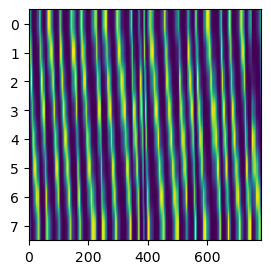

In [22]:


cfg = dict()
cfg['kappa'] = 2
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

print(np.shape(dat['phi_train']), np.shape(cfg))

design, sortedesign = dt.stim_features(dat['phi_train'], cfg)

print(np.shape(design), np.shape(sortedesign))

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto'
           
           # ,interpolation = 'none'
           )

# for comparing this script and the matlab one
import scipy
path_folds_data = '/Users/alex/Library/CloudStorage/OneDrive-UniversitatdeBarcelona/Projects/Condcision/Group_level_analyses/Beh_analyses/EEG_condcision_CJ/folds.mat'

mat = scipy.io.loadmat(path_folds_data)

idx_Train = mat['folds'][0][0].T
idx_Test =mat['folds'][1][0][0].T

#Folds_ori = Folds.copy()
dat = {}
dat['X_train'] = G[idx_Train-1] # -1 to correct for matlab to python indexes
dat['X_test'] = G[idx_Test-1]
dat['Y_train'] = np.squeeze(Y[:,sel_t, idx_Train-1])
dat['Y_test'] = np.squeeze(Y[:,sel_t, idx_Test-1])
dat['phi_train'] = phi[idx_Train-1]
dat['phi_test'] = phi[idx_Test-1]

Create design matrix

numC = 8 # how many channels to use

cfg = dict()
cfg['kappa'] = 4
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(dat['phi_train'], cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

Training encoding model

In [23]:
cfg = dict()
cfg['gamma'] = 0.01
cfg['demean'] = True
cfg['returnPattern'] = True

print(np.shape(design), np.shape(dat['Y_train']), np.shape(cfg))

decoder = dt.train_encoder(design, dat['Y_train'], cfg)

print(np.shape(decoder))

(8, 781) (32, 781) ()
()


Testing the encoding model

In [24]:
cfg = dict()
cfg['demean'] = 'traindata'

print(np.shape(decoder), np.shape(dat['Y_test']), np.shape(cfg))

Xhat = dt.test_encoder( decoder, dat['Y_test'], cfg)

print(np.shape(Xhat))

() (32, 782) ()
(8, 782)


__Preparing data for plotting results__

In [25]:
m = np.zeros((numC,numC))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, np.where(dat['X_test'] == (ic+1))[0]], axis = 1)


In [51]:
m.shape

(8, 8, 201)

Re-alligning predictions for trials with identical orientation

In [26]:
Xhat_centered = 0*Xhat.copy()
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:,np.where(dat['X_test'] == (ic+1))] = np.roll(Xhat[:,np.where(dat['X_test'] == (ic+1))], -ic, axis = 0)

In [27]:
m_centered = np.zeros((numC,numC))
for ic in range(numC):
   m_centered[:,ic] =  np.mean( Xhat_centered[:, np.where(dat['X_test'] == (ic+1))[0]], axis = 1)

In [28]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [29]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

-0.023582748566398613

Getting mean orientation values for each stimulus bin

In [30]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[np.where(dat['X_test'] == (ic+1))[0]] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

# Plotting results

[Text(0.0, 0, '0.0'),
 Text(22.5, 0, '22.5'),
 Text(45.0, 0, '45.0'),
 Text(67.5, 0, '67.5'),
 Text(90.0, 0, '90.0'),
 Text(112.5, 0, '112.5'),
 Text(135.0, 0, '135.0'),
 Text(157.5, 0, '157.5')]

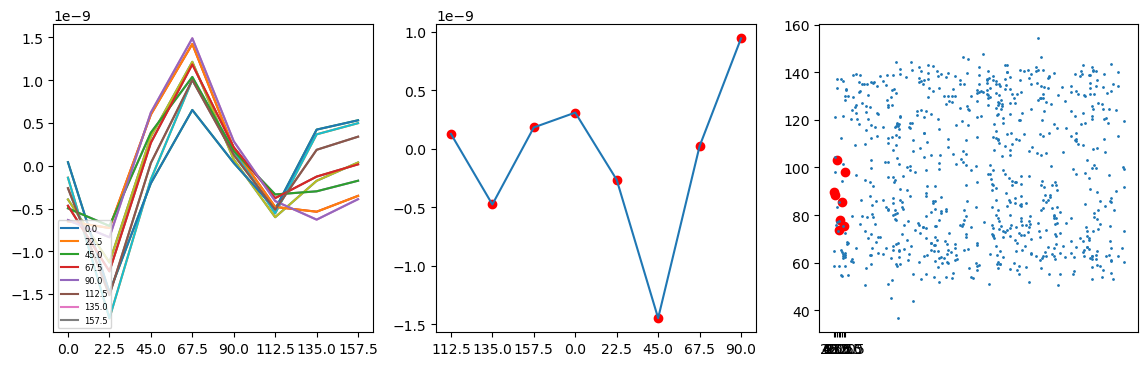

In [31]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(dat['phi_test'], theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


np.mean(np.exp(1j * (theta - dat['phi_test']) * (np.pi/180)*2))

__Preparing crossvalidation procedure__

In [32]:
import DecToolbox as dt
from importlib import reload  # Python 3.4+
reload(dt)

<module 'DecToolbox' from '/Users/junjieji/Desktop/master-thesis/DecToolbox.py'>

In [33]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

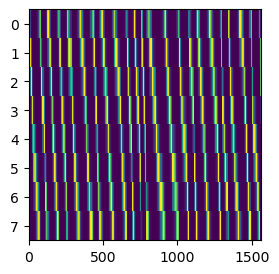

In [34]:
numC = 8 # how many channels to use

cfg = dict()
cfg['kappa'] = 4
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(phi, cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [35]:
from DecToolbox import CV_encoder
cfg = dict()
cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
cfg['cfgD'] = {'demean' : 'traindata'}
Xhat = CV_encoder(design, Y, sel_t, cfg, FoldsIdx)

In [36]:
m = np.zeros((numC,numC))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1)], axis = 1)

Re-alligning predictions for trials with identical orientation

In [37]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1)] = np.roll(Xhat[:,G == (ic+1)], -ic, axis = 0)
    m_centered[:,ic] =  np.mean( Xhat_centered[:,  G == (ic+1)], axis = 1)

In [38]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

In [39]:
# Kernel to back project channel outputs to orientation space
kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
Z = kernel @ Xhat

theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

r = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
r = np.abs(r) * np.cos(np.angle(r))
r

0.003457183372795371

Getting mean orientation values for each stimulus bin

In [40]:
mtheta = np.zeros(numC)
for ic in range(numC):
    mtheta[ic] = np.mod(np.angle(np.mean(np.exp(1j * theta[G == (ic+1)] * (np.pi/180)*2))), 2*np.pi) * (180/np.pi) / 2

# Plotting results

[Text(0.0, 0, '0.0'),
 Text(22.5, 0, '22.5'),
 Text(45.0, 0, '45.0'),
 Text(67.5, 0, '67.5'),
 Text(90.0, 0, '90.0'),
 Text(112.5, 0, '112.5'),
 Text(135.0, 0, '135.0'),
 Text(157.5, 0, '157.5')]

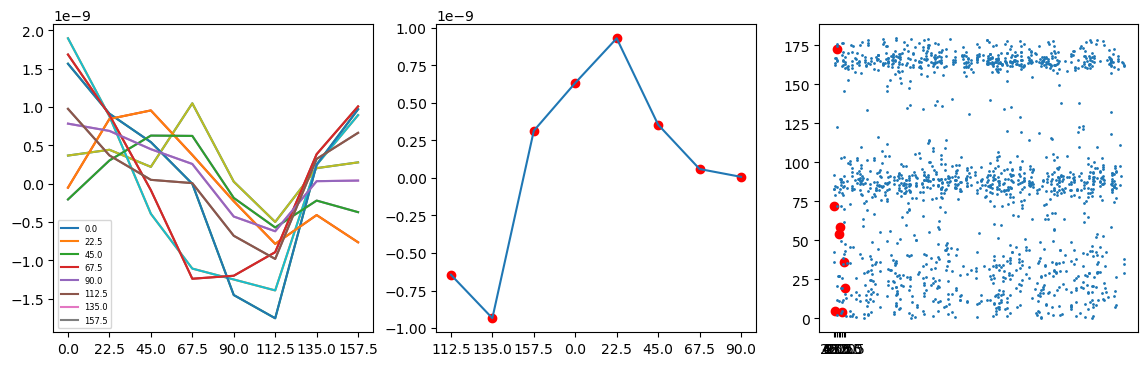

In [41]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(x_labels, m)
ax[0].plot(x_labels, m)
ax[0].set_xticks(x_labels)
ax[0].set_xticklabels(x_labels.astype(str))
ax[0].legend(x_labels, loc=3, prop={'size': 6})


ax[1].plot(x_labels, Xhat_shiftedmean)
ax[1].fill_between(x_labels, Xhat_shiftedmean-Xhat_shiftedsem, Xhat_shiftedmean+Xhat_shiftedsem)
ax[1].scatter(x_labels, Xhat_shiftedmean, color = 'red')
ax[1].set_xticks(x_labels)
ax[1].set_xticklabels(x_centeredlabels.astype(str))


ax[2].scatter(x_labels, mtheta, color = 'red')
ax[2].scatter(phi, theta, s = 1)
ax[2].set_xticks(x_labels)
ax[2].set_xticklabels(x_labels.astype(str))


__Temporal dimension decoding__

In [42]:
G = binned_phi.copy() # binning/discritizing orientation dimension to assign a balanced number of stimuli to different dat
CONDS = np.unique(G)
nConds = CONDS.size
nfold = 4
FoldsIdx = dt.CreateFolds(G, Y, nfold)

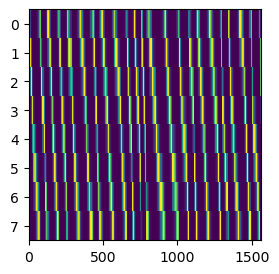

In [43]:
numC = 8 # how many channels to use

cfg = dict()
cfg['kappa'] = 4
cfg['NumC'] = numC
cfg['Tuning'] = 'vonmises'#'halfRectCos'
cfg['offset'] = 0

design, sortedesign = dt.stim_features(phi, cfg)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.imshow(sortedesign,aspect='auto',interpolation = 'none')

In [44]:
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it] = dt.CV_encoder(design, Y, it, cfg, FoldsIdx)
    
    

In [45]:
m = np.zeros((numC,numC, numT))
for ic in range(numC):
   m[:,ic] =  np.mean( Xhat[:, G == (ic+1),:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [46]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:] = np.roll(Xhat[:,G == (ic+1),:], -ic, axis = 0)
    m_centered[:,ic, : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :], axis = 1)

In [47]:
x_labels = np.array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])
Xhat_centeredmean = np.mean(Xhat_centered, axis = 1)
Xhat_centeredsem = np.std(m_centered, axis = 1)/Xhat.shape[1]
Xhat_shiftedmean = np.roll(Xhat_centeredmean, 3, axis = 0)
Xhat_shiftedsem = np.roll(Xhat_centeredsem, 3, axis = 0)
x_centeredlabels = np.roll(x_labels,  3, axis = 0)

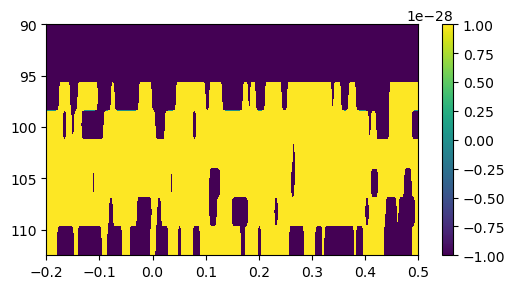

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(Xhat_shiftedmean,aspect='auto',vmin = -1e-28, vmax = 1e-28, interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()
#ax.set_xtickslabels(time)
#ax.set_Yticklabels(x_centeredlabels.astype(str))


__Crossmodal temporal generalization decoding__

In [49]:
import time as tic


In [50]:
start = tic.time()
numT = Y.shape[1]
Xhat = np.zeros([numC,numN, numT, numT])
for it in range(numT):
    cfg = dict()
    cfg['cfgE'] = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
    cfg['cfgD'] = {'demean' : 'traindata'}
    Xhat[:,:,it, :] = dt.CV_TG_encoder(design, Y, it, cfg, FoldsIdx)
end = tic.time()

KeyboardInterrupt: 

In [ ]:
(end-start)/60

1.3020691672960918

In [ ]:
m = np.zeros((numC,numC, numT, numT))
for ic in range(numC):
   m[:,ic, :, :] =  np.mean( Xhat[:, G == (ic+1),:,:], axis = 1)

Re-alligning predictions for trials with identical orientation

In [ ]:
Xhat_centered = 0*Xhat.copy()
m_centered = np.zeros((numC,numC, numT, numT))
for ic in range(numC): # here trials that match similar label orientation are shifted together x positions (np.roll)
    Xhat_centered[:, G == (ic+1),:, :] = np.roll(Xhat[:,G == (ic+1),:, :], -ic, axis = 0)
    m_centered[:,ic, : , : ] =  np.mean( Xhat_centered[:,  G == (ic+1), :, :], axis = 1)

Plotting diagonal values

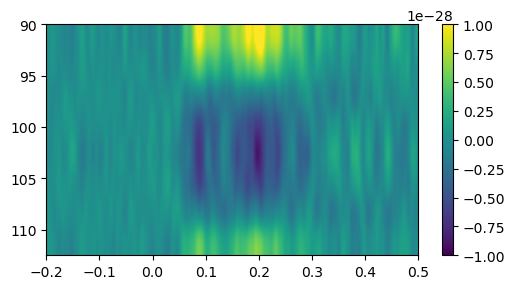

In [ ]:
diagonal_vals =  m_centered[:,:,range(numT),range(numT)]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plt.imshow(np.mean(diagonal_vals, axis = 1),aspect='auto',vmin = -1e-28, vmax = 1e-28, interpolation = 'gaussian',extent=[time[0],time[-1],x_centeredlabels[0], x_centeredlabels[-1]])
plt.colorbar()

Correlation between actual and predicted orientation values

In [ ]:
r = np.zeros((numT, numT))

for it1 in range(numT):
    for it2 in range(numT):
        # Kernel to back project channel outputs to orientation space
        kernel = np.exp(1j * (np.linspace(0, numC-1,numC)*(2*np.pi/numC)))
        Z = kernel @ Xhat[:,:, it1, it2]

        theta = np.mod(np.angle(Z), 2*np.pi) * (180/np.pi) / 2    # Decoded orientation (retain the module of the complex number)

        rs = np.mean(np.exp(1j * (theta - phi) * (np.pi/180)*2)) # correlation between decoded and presented orientation
        r[it1, it2] = np.abs(rs) * np.cos(np.angle(rs))
        r

In [ ]:
time_labels = [0, 0.2, 0.4, 0.6]

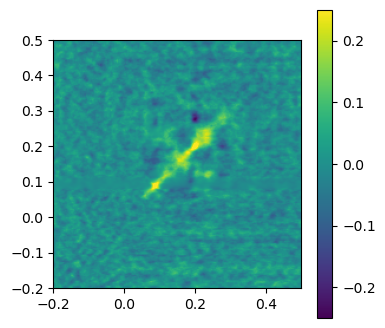

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plt.imshow(r, aspect= 1, interpolation = None, vmin = -0.25, vmax = 0.25, origin = 'lower',extent=[time[0],time[-1],time[0],time[-1]])
plt.colorbar()
#ax.set_xticklabels(time_labels)
#ax.set_yticklabels(time_labels)

In [ ]:
def CV_encoder(design, Y, sel_t, cfg, FoldsIdx):

    numC = design.shape[0]
    numN = Y.shape[2]

    Xhat = np.zeros([numC,numN])
    Xhat_centered = 0*Xhat.copy()

    nfold = np.size(FoldsIdx)

    for ifold in range(nfold):
        # Output matrix
        dat = dict()
        dat['Y_train'] = np.squeeze(Y[:,sel_t, FoldsIdx[ifold]['train_index']])
        idesign = design[:,FoldsIdx[ifold]['train_index']]
        dat['Y_test'] = np.squeeze(Y[:,sel_t, FoldsIdx[ifold]['test_index']])

        if 'cfgE' not in cfg:
            cfgE = {'gamma': 0.01, 'demean' : True, 'returnPattern' : True}
        else:
            cfgE = cfg['cfgE']

        decoder = dt.train_encoder(idesign, dat['Y_train'], cfgE)

        if 'cfgD' not in cfg:
            cfgD = {'demean' : 'traindata'}
        else:
            cfgD = cfg['cfgD']


        Xhat[:,FoldsIdx[ifold]['test_index']] = dt.test_encoder( decoder, dat['Y_test'], cfgD) 
    
    return Xhat

Getting mean orientation values for each stimulus bin

# Plotting results

In [ ]:
# Creating dat containing test and train indexes
nfold = 2

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=nfold,shuffle=False)
CrossValIdx = [None] * nfold
i = 0
for train_index, test_index  in  skf.split(X = np.zeros(numN), y = X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    CrossValIdx[i] = { 'train_index': train_index, 'test_index': test_index}
    i += 1

X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]
X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [ ]:

X_train = G[ CrossValIdx[0]['train_index']][:,np.newaxis]
Y_train = np.squeeze(Y[:,sel_t, CrossValIdx[0]['train_index']]).shape
phi_train = phi[ CrossValIdx[0]['train_index']][:,np.newaxis]
X_test = G[ CrossValIdx[0]['test_index']][:,np.newaxis]
Y_test = np.squeeze(Y[:,sel_t, CrossValIdx[0]['test_index']]).shape
phi_test = phi[ CrossValIdx[0]['test_index']][:,np.newaxis]

In [ ]:
# G[dat[0].astype(int)]

In [ ]:
dat = [np.array([])]*nfold

for iCond in range(nConds):
    # Find indexes
    indx = np.where(G == CONDS[iCond])[0]
    n_indx = indx.size 
    # Shuffle indexes
    indx = np.random.permutation(indx)
    # Distribute across dat
    nelemxfold = np.floor(indx.size/nfold)
    groupNumber = np.repeat(np.arange(0,nfold), nelemxfold)

    for iFold in range(nfold):
        dat[iFold] = np.append(dat[iFold], indx[np.where(groupNumber == iFold)])

 

In [ ]:
indx[np.where(groupNumber == iFold)]

array([324, 294,  98, 677,  83, 519, 236, 494, 257, 695, 592, 450,  81,
       361, 270,  25, 155,  45, 149, 470, 746, 627, 393, 459,  42,   3,
       326, 589, 351, 279, 703, 544, 113, 260, 402,  20, 663, 306, 140,
       169, 481, 303, 541,  64, 742, 193, 416])